In [1]:
!pip install xlrd
!pip install adversarial-robustness-toolbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 46.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.19.2 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.3 which is incompatible.


In [2]:
import sys
import os
import pandas as pd
import numpy as np
import requests, io
import matplotlib.pyplot as plt
from google.colab import drive
from numpy import mean
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dropout
from keras.constraints import MaxNorm
from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from art.attacks.inference.membership_inference import MembershipInferenceBlackBox
from art.estimators.classification import KerasClassifier
from sklearn.metrics import classification_report

tf.compat.v1.disable_eager_execution()

drive.mount('/content/drive', force_remount=True)
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/'

dataset = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/PUDF_base1q2009_tab.csv")
dataset = dataset.dropna()
dataset = dataset.drop(['RECORD_ID','PAT_AGE','PAT_STATUS'],axis=1)
dataset['SEX_CODE'] = pd.Categorical(dataset['SEX_CODE']).codes
dataset['ADMITTING_DIAGNOSIS'] = pd.Categorical(dataset['ADMITTING_DIAGNOSIS']).codes
dataset['PRINC_DIAG_CODE'] = pd.Categorical(dataset['PRINC_DIAG_CODE']).codes
dataset['OTH_DIAG_CODE_1'] = pd.Categorical(dataset['OTH_DIAG_CODE_1']).codes
dataset['OCCUR_DAY_1'] = pd.Categorical(dataset['OCCUR_DAY_1']).codes
dataset['OCCUR_CODE_1'] = pd.Categorical(dataset['OCCUR_CODE_1']).codes
dataset['HCFA_MDC'] = pd.Categorical(dataset['HCFA_MDC']).codes
dataset['ETHNICITY'] = pd.Categorical(dataset['ETHNICITY']).codes
dataset['SOURCE_OF_ADMISSION'] = pd.Categorical(dataset['SOURCE_OF_ADMISSION']).codes
dataset['RACE'] = pd.Categorical(dataset['RACE']).codes
dataset['LENGTH_OF_STAY'] = pd.Categorical(dataset['LENGTH_OF_STAY']).codes
dataset['TYPE_OF_ADMISSION'] = pd.Categorical(dataset['TYPE_OF_ADMISSION']).codes
dataset['APR_MDC'] = pd.Categorical(dataset['APR_MDC']).codes
dataset['HCFA_DRG'] = pd.Categorical(dataset['HCFA_DRG']).codes
dataset['APR_DRG'] = pd.Categorical(dataset['APR_DRG']).codes
dataset['ILLNESS_SEVERITY'] = pd.Categorical(dataset['ILLNESS_SEVERITY']).codes
dataset['RISK_MORTALITY'] = pd.Categorical(dataset['RISK_MORTALITY']).codes
RISK_MORTALITY_MAP = {1:0,2:1,3:2,4:3}
dataset['RISK_MORTALITY'] = dataset['RISK_MORTALITY'].replace(RISK_MORTALITY_MAP)

#dataset = dataset.iloc[:380000]
print(dataset.size)
dataset.tail()

Mounted at /content/drive


<ipython-input-2-fc235f2f91da>:35: DtypeWarning: Columns (1,6,7,12) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/PUDF_base1q2009_tab.csv")


8091609


,SEX_CODE,TYPE_OF_ADMISSION,SOURCE_OF_ADMISSION,LENGTH_OF_STAY,RACE,ETHNICITY,ADMITTING_DIAGNOSIS,PRINC_DIAG_CODE,OTH_DIAG_CODE_1,OCCUR_CODE_1,OCCUR_DAY_1,HCFA_MDC,APR_MDC,HCFA_DRG,APR_DRG,ILLNESS_SEVERITY,RISK_MORTALITY
737667,0,1,5,47,10,3,1727,1989,2480,37,0,4,4,725,302,4,2
737668,0,1,5,13,10,3,2857,3175,2474,37,0,8,8,725,302,4,3
737669,1,2,5,19,9,4,1729,1991,1998,2,689,4,4,725,304,3,2
737672,1,2,5,23,9,4,1668,1897,4457,2,689,4,4,726,302,3,0
737673,0,2,0,4,9,4,1519,673,3627,2,689,10,8,732,142,2,0


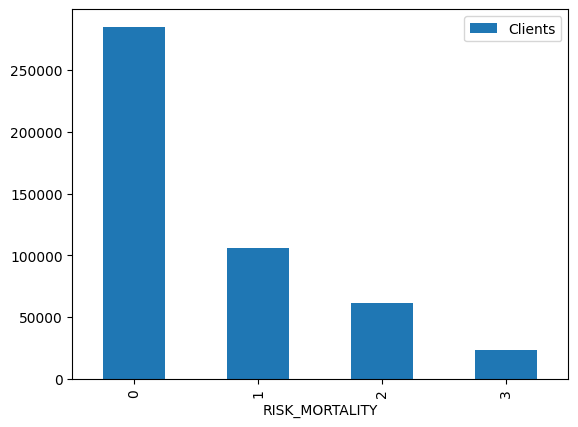

4845357
1802034
1042831
401387


In [5]:
data = {
  "RISK_MORTALITY": [0,1,2,3],
  "Clients": [len(dataset.query("RISK_MORTALITY == 0")),
              len(dataset.query("RISK_MORTALITY == 1")),
              len(dataset.query("RISK_MORTALITY == 2")),
              len(dataset.query("RISK_MORTALITY == 3"))]
}

#load data into a DataFrame object:
df = pd.DataFrame(data)

df.plot(kind = 'bar', x='RISK_MORTALITY',y = 'Clients')
plt.show()
print(dataset.query("RISK_MORTALITY == 0").size)
print(dataset.query("RISK_MORTALITY == 1").size)
print(dataset.query("RISK_MORTALITY == 2").size)
print(dataset.query("RISK_MORTALITY == 3").size)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

sm_dataset_0 = dataset.query("RISK_MORTALITY == 0").iloc[1:60000]
sm_dataset_1 = dataset.query("RISK_MORTALITY == 1").iloc[1:60000]
sm_dataset_2 = dataset.query("RISK_MORTALITY == 2").iloc[1:60000]
sm_dataset_3 = dataset.query("RISK_MORTALITY == 3").iloc[1:60000]
sm_dataset = pd.concat([sm_dataset_0, sm_dataset_1, sm_dataset_2, sm_dataset_3])
sm_dataset.head()
print(len(sm_dataset_0))
print(len(sm_dataset_1))
print(len(sm_dataset_2))
print(len(sm_dataset_3))
#scaler = MinMaxScaler()
#X_orig = sm_dataset.to_numpy()
#X_orig = scaler.fit_transform(X_orig)
#np.unique(X_orig[:-1])
#X_orig.shape

59999
59999
59999
23610


In [ ]:
"""Python implementation of SMOTE.
This implementation is based on the original variant of SMOTE.
Original paper: https://www.jair.org/media/953/live-953-2037-jair.pdf
"""
class PPSMOTE:

    def __init__(self, ratio=100, k_neighbors=2, random_state=None):
        if ratio > 0 and ratio < 100:
            self.ratio = ratio
        elif ratio >= 100:
            if ratio % 100 == 0:
                self.ratio = ratio
            else:
                raise ValueError(
                    'ratio over 100 should be multiples of 100')
        else:
            raise ValueError(
                'ratio should be greater than 0')

        if type(k_neighbors) == int:
            if k_neighbors > 0:
                self.k_neighbors = k_neighbors
            else:
                raise ValueError(
                    'k_neighbors should be integer greater than 0')
        else:
            raise TypeError(
                'Expect integer for k_neighbors')

        if type(random_state) == int:
            np.random.seed(random_state)

    def _laplaceNoise(self, mu, b, size):
        return np.random.laplace(mu, b, size)

    def _randomize(self, samples, ratio):
        length = samples.shape[0]
        target_size = length * ratio
        idx = np.random.randint(length, size=target_size)

        return samples[idx, :]

    def _populate(self, idx, nnarray):
        noise = self._laplaceNoise(0.5, 0.00001, 17)

        for i in range(self.N):
            nn = np.random.randint(low=0, high=self.k_neighbors)
            for attr in range(self.numattrs):
                dif = (self.samples[nnarray[nn]][attr] - self.samples[idx][attr])
                #gap = np.random.uniform()
                self.synthetic[self.newidx][attr] = (self.samples[idx][attr] + noise[attr] * dif)
            self.newidx += 1

    def oversample(self, samples, merge=False):

        if type(samples) == list:
            self.samples = np.array(samples)
        elif type(samples) == np.ndarray:
            self.samples = samples
        else:
            raise TypeError(
                'Expect a built-in list or an ndarray for samples')

        self.numattrs = self.samples.shape[1]

        if self.ratio < 100:
            ratio = ratio / 100.0
            self.samples = self._randomize(self.samples, ratio)
            self.ratio = 100

        self.N = int(self.ratio / 100)
        new_shape = (self.samples.shape[0] * self.N, self.samples.shape[1])
        self.synthetic = np.empty(shape=new_shape)
        self.newidx = 0

        self.nbrs = NearestNeighbors(n_neighbors=self.k_neighbors)
        self.nbrs.fit(samples)
        self.knn = self.nbrs.kneighbors()[1]

        for idx in range(self.samples.shape[0]):
            nnarray = self.knn[idx]
            self._populate(idx, nnarray)

        if merge:
            return np.concatenate((self.samples, self.synthetic))
        else:
            return self.synthetic
smt = PPSMOTE(ratio=100, k_neighbors=2)
synthetic_samples = smt.oversample(sm_dataset_1.to_numpy())
pp_sm_dataset = smt.oversample(sm_dataset_1.to_numpy(), merge=True)
sm_dataset_1=pd.DataFrame(pp_sm_dataset)
pp_sm_dataset.shape


(119998, 17)

In [ ]:
X_train_1 = sm_dataset_0.to_numpy()[1:60000,:]
X_train_2 = sm_dataset_1.to_numpy()[60000:119998,:]
X_train_3 = sm_dataset_2.to_numpy()[60000:119998,:]
X_train_4 = sm_dataset_3.to_numpy()[1:60000,:]
X_train_5 =np.concatenate((X_train_1,X_train_2,X_train_3,X_train_4),axis=0)
X_train_5.shape
np.unique(X_train_5[:,-1])

array([0., 1., 2., 3.])

In [ ]:
X_train_5[:,:16].shape

(239993, 16)

In [ ]:
X_trains_1 = sm_dataset_0.to_numpy()[1:60000,:]
X_trains_2 = sm_dataset_1.to_numpy()[1:10000,:]
X_trains_3 = sm_dataset_2.to_numpy()[1:10000,:]
X_trains_4 = sm_dataset_3.to_numpy()[1:10000,:]
X_train_5 =np.concatenate((X_trains_1,X_trains_2,X_trains_3,X_trains_4),axis=0)
X_train_5.shape
np.unique(X_train_5[:,-1])

array([0, 1, 2, 3], dtype=int16)

In [ ]:
#smt = SMOTE()
#smt = ADASYN()
#smt = BorderlineSMOTE(random_state = 42, kind = 'borderline-1')
#smt = SMOTEENN(random_state=42)
#smt = SMOTETomek(random_state = 42)
#smt = SVMSMOTE(random_state = 42)
smt = KMeansSMOTE(random_state=42)
X = X_train_5[:,:16]
y = X_train_5[:,-1]

X_train_5, y_train_5 = smt.fit_resample(X, y)
np.unique(y_train_5)
X_train_5[:,:16].shape

(239995, 16)

In [ ]:
def _splitData(X_train_5):
  X_train, X_test, y_train, y_test = train_test_split(X_train_5[:,:16],X_train_5[:,-1], random_state=104,test_size=0.5,shuffle=True)
  #X_train, X_test, y_train, y_test = train_test_split(X_train_5,y_train_5, random_state=104,test_size=0.5,shuffle=True)
  scaler = MinMaxScaler()
  label_encoder = LabelEncoder()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.fit_transform(X_test)
  label_encoder.fit(y_train)
  label_encoder.fit(y_test)
  y_train = label_encoder.transform(y_train)
  y_test = label_encoder.transform(y_test)
  return X_train, X_test, y_train, y_test

def _buildModel(X_train, X_test, y_train, y_test):
  #os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
  optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
  loss = tf.keras.losses.SparseCategoricalCrossentropy()

  model = Sequential()
  model.add(Dense(16, activation='relu', input_dim=16, kernel_constraint=MaxNorm(3)))
  model.add(Dropout(0.3))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(16, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(4, activation='softmax'))
  model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
  #model.summary()
  history = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        batch_size=128,
                        epochs=30,
                        verbose=0)
  pred_val = model.predict(X_test)
  #fpr, tpr, threshold = roc_curve(y_test, pred_val, pos_label=1)
  #random_pred_val = [0 for i in range(len(y_test))]
  #p_fpr1, p_tpr1, _ = roc_curve(y_test, random_pred_val, pos_label=1)
  auc_score = roc_auc_score(y_test, pred_val, multi_class='ovr')
  print(f"AUC SCORE: {auc_score:6f}")
  return model, auc_score

def calc_precision_recall(predicted, actual, positive_value=1):
    score = 0  # both predicted and actual are positive
    num_positive_predicted = 0  # predicted positive
    num_positive_actual = 0  # actual positive
    for i in range(len(predicted)):
        if predicted[i] == positive_value:
            num_positive_predicted += 1
        if actual[i] == positive_value:
            num_positive_actual += 1
        if predicted[i] == actual[i]:
            if predicted[i] == positive_value:
                score += 1

    if num_positive_predicted == 0:
        precision = 1
    else:
        precision = score / num_positive_predicted  # the fraction of predicted “Yes” responses that are correct
    if num_positive_actual == 0:
        recall = 1
    else:
        recall = score / num_positive_actual  # the fraction of “Yes” responses that are predicted correctly
    return precision, recall

def _attackMIA(X_train, X_test, y_train, y_test, model):
  attack_train_ratio = 0.5
  attack_train_size = int(len(X_train) * attack_train_ratio)
  attack_test_size = int(len(X_test) * attack_train_ratio)

  mlp_art_model = KerasClassifier(model=model, clip_values=(0, 1))

  mlp_attack_bb = MembershipInferenceBlackBox(mlp_art_model, attack_model_type='rf')

  mlp_attack_bb.fit(X_train[:attack_train_size].astype(np.float32),y_train[:attack_train_size].astype(np.float32),
                    X_test[:attack_test_size].astype(np.float32), y_test[:attack_test_size].astype(np.float32))
  mlp_inferred_train_bb = mlp_attack_bb.infer(X_train[attack_train_size:].astype(np.float32), y_train[attack_train_size:])
  mlp_inferred_test_bb = mlp_attack_bb.infer(X_test[attack_test_size:].astype(np.float32), y_test[attack_test_size:])

  mlp_train_acc_bb = np.sum(mlp_inferred_train_bb) / len(mlp_inferred_train_bb)
  mlp_test_acc_bb = 1-(np.sum(mlp_inferred_test_bb) / len(mlp_inferred_test_bb))
  mlp_acc_bb = (mlp_train_acc_bb * len(mlp_inferred_train_bb) + mlp_test_acc_bb * len(mlp_inferred_test_bb)) / (len(mlp_inferred_train_bb) + len(mlp_inferred_test_bb))

  #print(f"Members Accuracy: {mlp_train_acc_bb:.4f}")
  #print(f"Non Members Accuracy {mlp_test_acc_bb:.4f}")
  #print(f"Attack Accuracy {mlp_acc_bb:.4f}")

  precision, recall = calc_precision_recall(np.concatenate((mlp_inferred_train_bb, mlp_inferred_test_bb)),
                              np.concatenate((np.ones(len(mlp_inferred_train_bb)), np.zeros(len(mlp_inferred_test_bb)))))
  y_train_pred = np.concatenate((mlp_inferred_train_bb, mlp_inferred_test_bb))
  y_train_true = np.concatenate((np.ones_like(mlp_inferred_train_bb), np.zeros_like(mlp_inferred_test_bb)))
  #print(classification_report(y_pred=y_train_pred, y_true=y_train_true))
  return mlp_train_acc_bb, mlp_test_acc_bb, mlp_acc_bb, precision, recall


In [ ]:
import concurrent.futures
import threading

num_iterations = 20
auc = []
member  = []
nonmember = []
att = []
prec = []
rec = []

def execAttack(lock):
  with lock:
    #print("Attack executed.")
    X_train, X_test, y_train, y_test = _splitData(X_train_5)
    model, auc_score = _buildModel(X_train, X_test, y_train, y_test)
    mlp_train_acc_bb, mlp_test_acc_bb, mlp_acc_bb, precision, recall = _attackMIA(X_train, X_test, y_train, y_test, model)
    #print(f"AUC SCORE,Members Accuracy,Non Members Accuracy,Attack Accuracy,Attack Precision,Attack Recall")
    print(f"{auc_score:4f},{mlp_train_acc_bb:4f},{mlp_test_acc_bb:4f},{mlp_acc_bb:4f},{precision:4f},{recall:4f}")
    auc.append(auc_score)
    member.append(mlp_train_acc_bb)
    nonmember.append(mlp_test_acc_bb)
    att.append(mlp_acc_bb)
    prec.append(precision)
    rec.append(recall)

with concurrent.futures.ThreadPoolExecutor() as executor:
    lock = threading.Lock()
    futures = [executor.submit(execAttack,lock) for _ in range(num_iterations)]
    concurrent.futures.wait(futures)
ppldf = pd.DataFrame()
ppldf['AUC'] = np.array(auc)
ppldf['Member_Accuracy'] = np.array(member)
ppldf['Non_Member_Accuracy'] = np.array(nonmember)
ppldf['Attack_accuracy'] = np.array(att)
ppldf['Precision'] = np.array(prec)
ppldf['Recall'] = np.array(rec)
#ppldf.head()
ppldf.to_csv("/content/drive/MyDrive/Colab Notebooks/results/Classes_4/result_4c_100000.csv")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


AUC SCORE: 0.894343
0.894343,0.505684,0.536426,0.521055,0.521718,0.505684


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


AUC SCORE: 0.901713
0.901713,0.523501,0.526592,0.525046,0.525120,0.523501


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


AUC SCORE: 0.899283
0.899283,0.503650,0.544259,0.523955,0.524964,0.503650


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


AUC SCORE: 0.897147
0.897147,0.513800,0.532926,0.523363,0.523814,0.513800


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


AUC SCORE: 0.899559
0.899559,0.506434,0.533526,0.519980,0.520532,0.506434


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


AUC SCORE: 0.905468
0.905468,0.516451,0.535042,0.525746,0.526230,0.516451


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


AUC SCORE: 0.917624
0.917624,0.529484,0.513675,0.521580,0.521240,0.529484


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


AUC SCORE: 0.902157
0.902157,0.491250,0.556943,0.524096,0.525786,0.491250


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


AUC SCORE: 0.905603
0.905603,0.516401,0.526409,0.521405,0.521617,0.516401


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


AUC SCORE: 0.927470
0.927470,0.518934,0.529542,0.524238,0.524494,0.518934


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


AUC SCORE: 0.912500
0.912500,0.532318,0.510692,0.521505,0.521045,0.532318


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


AUC SCORE: 0.910908
0.910908,0.508550,0.537326,0.522938,0.523613,0.508550


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


AUC SCORE: 0.907526
0.907526,0.504817,0.546876,0.525846,0.526977,0.504817


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


AUC SCORE: 0.910204
0.910204,0.549568,0.498908,0.524238,0.523065,0.549568


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


AUC SCORE: 0.921113
0.921113,0.491616,0.556793,0.524205,0.525888,0.491616


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


AUC SCORE: 0.924954
0.924954,0.501500,0.543792,0.522646,0.523642,0.501500


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


AUC SCORE: 0.898196
0.898196,0.509100,0.531942,0.520521,0.520997,0.509100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


AUC SCORE: 0.893494
0.893494,0.521384,0.528159,0.524771,0.524936,0.521384


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


AUC SCORE: 0.912463
0.912463,0.505617,0.543192,0.524405,0.525353,0.505617


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


AUC SCORE: 0.904866
0.904866,0.473749,0.567426,0.520588,0.522711,0.473749


In [ ]:
batch_size = 256
X_train, X_test, y_train, y_test = train_test_split(X_train_5[:,:16],X_train_5[:,-1], random_state=104,test_size=0.50,shuffle=True)
#X_train, X_test, y_train, y_test = train_test_split(X_train_5,y_train_5, random_state=104,test_size=0.50,shuffle=True)

In [ ]:
scaler = MinMaxScaler()
label_encoder = LabelEncoder()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
label_encoder.fit(y_train)
label_encoder.fit(y_test)
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)
np.unique(y_train)

array([0, 1, 2, 3])

In [ ]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#model = Sequential()
#model.add(Dense(16, activation='relu', input_dim=16))
#model.add(Dense(32, activation='relu'))
#model.add(Dense(4, activation='softmax'))
#model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
#model.summary()
model = Sequential()
model.add(Dense(16, activation='relu', input_dim=16, kernel_constraint=MaxNorm(3)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                272       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                1088      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 16)                5

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


In [ ]:
history = model.fit(X_train, y_train,
                       validation_data=(X_test, y_test),
                       batch_size=128,
                       epochs=30)

Train on 119996 samples, validate on 119997 samples
Epoch 1/30
119040/119996 [============================>.] - ETA: 0s - loss: 1.0606 - accuracy: 0.5148

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


119996/119996 [==============================] - 4s 34us/sample - loss: 1.0590 - accuracy: 0.5158 - val_loss: 0.8335 - val_accuracy: 0.6588
Epoch 2/30
119996/119996 [==============================] - 3s 25us/sample - loss: 0.8623 - accuracy: 0.6391 - val_loss: 0.8718 - val_accuracy: 0.6053
Epoch 3/30
119996/119996 [==============================] - 2s 20us/sample - loss: 0.8309 - accuracy: 0.6541 - val_loss: 0.8439 - val_accuracy: 0.6456
Epoch 4/30
119996/119996 [==============================] - 2s 20us/sample - loss: 0.8158 - accuracy: 0.6616 - val_loss: 0.8606 - val_accuracy: 0.6195
Epoch 5/30
119996/119996 [==============================] - 2s 21us/sample - loss: 0.8092 - accuracy: 0.6645 - val_loss: 0.8861 - val_accuracy: 0.5719
Epoch 6/30
119996/119996 [==============================] - 3s 26us/sample - loss: 0.8044 - accuracy: 0.6658 - val_loss: 0.8215 - val_accuracy: 0.6498
Epoch 7/30
119996/119996 [==============================] - 4s 31us/sample - loss: 0.7977 - accuracy: 0.6

In [ ]:
from art.attacks.inference.membership_inference import MembershipInferenceBlackBox
from art.estimators.classification import KerasClassifier

mlp_art_model = KerasClassifier(model=model, clip_values=(0, 1))
#mlp_art_model.fit(X_train, y_train, nb_epochs=20, batch_size=128)

train_pred = mlp_art_model.predict(X_train.astype(np.float32))
eq2 = (np.argmax(train_pred, 1) == y_train)
acc = eq2.mean()
print('Base model Train accuracy: ', acc)

test_pred = mlp_art_model.predict(X_test.astype(np.float32))
eq2 = (np.argmax(test_pred, 1) == y_test)
acc = eq2.mean()
print('Base model test accuracy: ', acc)

#adv_crafter = FastGradientMethod(mlp_art_model, eps=0.2)
#x_test_adv = adv_crafter.generate(x=X_test, y=y_test)

# Evaluate the classifier on the adversarial examples
#preds = np.argmax(mlp_art_model.predict(x_test_adv), axis=1)
#acc = np.sum(preds == np.argmax(y_test, axis=0)) / y_test.shape[0]
#print("Test accuracy on adversarial sample (epsilon = %.2f): %.2f%%" % (0.2, acc * 100))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Base model Train accuracy:  0.6413963798793293
Base model test accuracy:  0.5955065543305249


In [ ]:
def calc_precision_recall(predicted, actual, positive_value=1):
    score = 0  # both predicted and actual are positive
    num_positive_predicted = 0  # predicted positive
    num_positive_actual = 0  # actual positive
    for i in range(len(predicted)):
        if predicted[i] == positive_value:
            num_positive_predicted += 1
        if actual[i] == positive_value:
            num_positive_actual += 1
        if predicted[i] == actual[i]:
            if predicted[i] == positive_value:
                score += 1

    if num_positive_predicted == 0:
        precision = 1
    else:
        precision = score / num_positive_predicted  # the fraction of predicted “Yes” responses that are correct
    if num_positive_actual == 0:
        recall = 1
    else:
        recall = score / num_positive_actual  # the fraction of “Yes” responses that are predicted correctly

    return precision, recall

In [ ]:
attack_train_ratio = 0.5
attack_train_size = int(len(X_train) * attack_train_ratio)
attack_test_size = int(len(X_test) * attack_train_ratio)

mlp_attack_bb = MembershipInferenceBlackBox(mlp_art_model, attack_model_type='rf')
mlp_attack_bb.fit(X_train[:attack_train_size].astype(np.float32),y_train[:attack_train_size].astype(np.float32),
                  X_test[:attack_test_size].astype(np.float32), y_test[:attack_test_size].astype(np.float32))

mlp_inferred_train_bb = mlp_attack_bb.infer(X_train[attack_train_size:].astype(np.float32), y_train[attack_train_size:])
mlp_inferred_test_bb = mlp_attack_bb.infer(X_test[attack_test_size:].astype(np.float32),y_test[attack_test_size:])

mlp_train_acc_bb = np.sum(mlp_inferred_train_bb) / len(mlp_inferred_train_bb)
mlp_test_acc_bb = 1-(np.sum(mlp_inferred_test_bb) / len(mlp_inferred_test_bb))
mlp_acc_bb = (mlp_train_acc_bb * len(mlp_inferred_train_bb) + mlp_test_acc_bb * len(mlp_inferred_test_bb)) / (len(mlp_inferred_train_bb) + len(mlp_inferred_test_bb))

print(f"Members Accuracy: {mlp_train_acc_bb:.4f}")
print(f"Non Members Accuracy {mlp_test_acc_bb:.4f}")
print(f"Attack Accuracy {mlp_acc_bb:.4f}")

print(calc_precision_recall(np.concatenate((mlp_inferred_train_bb, mlp_inferred_test_bb)),
                            np.concatenate((np.ones(len(mlp_inferred_train_bb)), np.zeros(len(mlp_inferred_test_bb))))))

Members Accuracy: 0.6588
Non Members Accuracy 0.6597
Attack Accuracy 0.6592
(0.6593764075872078, 0.6587719590653022)


In [ ]:
from sklearn.metrics import classification_report

y_train_pred = np.concatenate((mlp_inferred_train_bb, mlp_inferred_test_bb))
y_train_true = np.concatenate((np.ones_like(mlp_inferred_train_bb), np.zeros_like(mlp_inferred_test_bb)))
print(classification_report(y_pred=y_train_pred, y_true=y_train_true))

              precision    recall  f1-score   support

         0.0       0.68      0.69      0.68     39347
         1.0       0.68      0.68      0.68     39347

    accuracy                           0.68     78694
   macro avg       0.68      0.68      0.68     78694
weighted avg       0.68      0.68      0.68     78694



In [ ]:
import numpy as np
import math

dataset = X_orig

l1_norm_sensitivity = 0

for i, data_point in enumerate(dataset):
    temp_dataset = np.delete(dataset, i, axis=0)

    l1_norm_orig = np.linalg.norm(dataset, ord=1)
    l1_norm_temp = np.linalg.norm(temp_dataset, ord=1)

    diff = abs(l1_norm_orig - l1_norm_temp)

    l1_norm_sensitivity = max(l1_norm_sensitivity, diff)

print("L1 Norm Sensitivity:",l1_norm_sensitivity)


L1 Norm Sensitivity: 1.0


In [ ]:
import numpy as np

# Set the parameters
mean_value = 0.5
scale_value = 0.01
sample_size = 17

# Generate a sample from Laplace distribution
laplace_sample = np.random.laplace(loc=mean_value, scale=scale_value, size=sample_size)

# Display the generated sample
print("Generated Laplace Sample:")
print(laplace_sample)


Generated Laplace Sample:
[0.51847934 0.506432   0.48727558 0.49658962 0.4878354  0.50255694
 0.50919559 0.47569822 0.51995735 0.5035837  0.49161375 0.51014432
 0.50682058 0.4948636  0.49414809 0.48617123 0.48679784]
